In [1]:
import os
import time
import pickle
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import shap

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import lightgbm as lgbm
import xgboost as xgb

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_validate, cross_val_score, KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler

from yellowbrick.classifier import ClassificationReport, ConfusionMatrix, DiscriminationThreshold, PrecisionRecallCurve, ROCAUC
import scikitplot as skplt

from hyperopt import hp, STATUS_OK, Trials, fmin, tpe
from hyperopt.pyll import scope

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline as Pipe_imb


warnings.filterwarnings('ignore')

## Funções

In [2]:
def viz_performance(X_train, X_test, y_train, y_test, clf, classes, figsize=(12, 16), cmap='Greens'):

    fig, ax = plt.subplots(3, 2, figsize=figsize)
    
    lr = clf.fit(X_train, y_train)
    y_probas = lr.predict_proba(X_test)
    skplt.metrics.plot_ks_statistic(y_test, y_probas, ax=ax[2,1])
    
    grid = [
        ConfusionMatrix(clf, ax=ax[0, 0], classes=classes, cmap=cmap),
        ClassificationReport(clf, ax=ax[0, 1], classes=classes, cmap=cmap ),
        PrecisionRecallCurve(clf, ax=ax[1, 0]),
        ROCAUC(clf, ax=ax[1, 1], micro=False, macro=False, per_class=True, classes=classes),
        DiscriminationThreshold(clf, ax=ax[2,0])
    ]
    
    for viz in grid:
        viz.fit(X_train, y_train)
        viz.score(X_test, y_test)
        viz.finalize()

    plt.tight_layout()
    plt.show()



def hyperopt(param_space, X_train, y_train, X_test, y_test, num_eval):
    
    start = time.time()
    
    def objective_function(params):
        clf = lgbm.LGBMClassifier(**params)
        score = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc').mean()
        return {'loss': -score, 'status': STATUS_OK}

    trials = Trials()
    best_param = fmin(objective_function, 
                      param_space, 
                      algo=tpe.suggest, 
                      max_evals=num_eval, 
                      trials=trials,
                      rstate= np.random.RandomState(1))
    loss = [x['result']['loss'] for x in trials.trials]
    
    best_param_values = [x for x in best_param.values()]
    
    
    if best_param_values[0] == 0:
        boosting_type = 'gbdt'
    else:
        boosting_type= 'dart'
    
    clf_best = lgbm.LGBMClassifier(learning_rate=best_param_values[3],
                                   num_leaves=int(best_param_values[6]),
                                   max_depth=int(best_param_values[4]),
                                   n_estimators=int(best_param_values[5]),
                                   boosting_type=boosting_type,
                                   colsample_bytree=best_param_values[1],
                                   reg_lambda=best_param_values[8],
                                   reg_alpha =  best_param_values[7],
                                   feature_fraction = best_param_values[2],
                                   random_state=SEED
                                  )
                                  
    clf_best.fit(X_train, y_train)
    
    print("")
    print("##### Results")
    print("Score best parameters: ", min(loss)*-1)
    print("Best parameters: ", best_param)
    print("Test Score: ", clf_best.score(X_test, y_test))
    print("Time elapsed: ", time.time() - start)
    print("Parameter combinations evaluated: ", num_eval)
    
    return (best_param, clf_best)

## Sumário

## Sumário

1. [Ingestão dos dados](#ingestion)
2. [Model Selection](#modelselect)
3. [LightGBM](#model)
4. [Oversample and Undersample](#over)
5. [Modelo final](#modelend)
6. [Salvando modelo](#savmodel)
7. [Previsão](#pred)
8. [Salvando previsão](#savpred)
9. [Considerações](#conside)

## Ingestão de dados

In [3]:
DATA_RAW_PATH = os.path.join('..','data','raw')
DATA_INTER_TRAIN_NAME = 'df_train.csv'
DATA_RAW_TEST_NAME = 'teste.csv'
DATA_PROCE_TRAIN_NAME = 'df_train.csv'
DATA_PROCE_TEST_NAME = 'df_test.csv'
DATA_INTER_PATH = os.path.join('..','data','interim')
DATA_INTER_PROCESSED = os.path.join('..', 'data', 'processed')
DATA_PREDICT = os.path.join('..', 'data', 'processed')
DATA_PREDICT_NAME = 'predicted.csv'
MODEL_PATH = os.path.join('..', 'models')
MODEL_NAME = 'model.pkl'
IMG_PATH = os.path.abspath(os.path.join('..','reports', 'figures'))
SEED=1

In [4]:
train = pd.read_csv(os.path.join(DATA_INTER_PROCESSED, DATA_PROCE_TRAIN_NAME))
target = train['inadimplente']
train = train.drop('inadimplente', axis=1)

test = pd.read_csv(os.path.join(DATA_INTER_PROCESSED, DATA_PROCE_TEST_NAME))

print('shape dados de treino: ', train.shape)
print('shape dados de teste: ', test.shape)

shape dados de treino:  (82709, 10)
shape dados de teste:  (40000, 10)


In [5]:
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit_transform(train)

X_train, X_test, y_train, y_test = train_test_split(train, target,
                                                    test_size=.3,
                                                    random_state=SEED,
                                                    stratify=target)

In [6]:
reglog = LogisticRegression(class_weight='balanced',
                            solver='saga',
                            random_state=SEED)

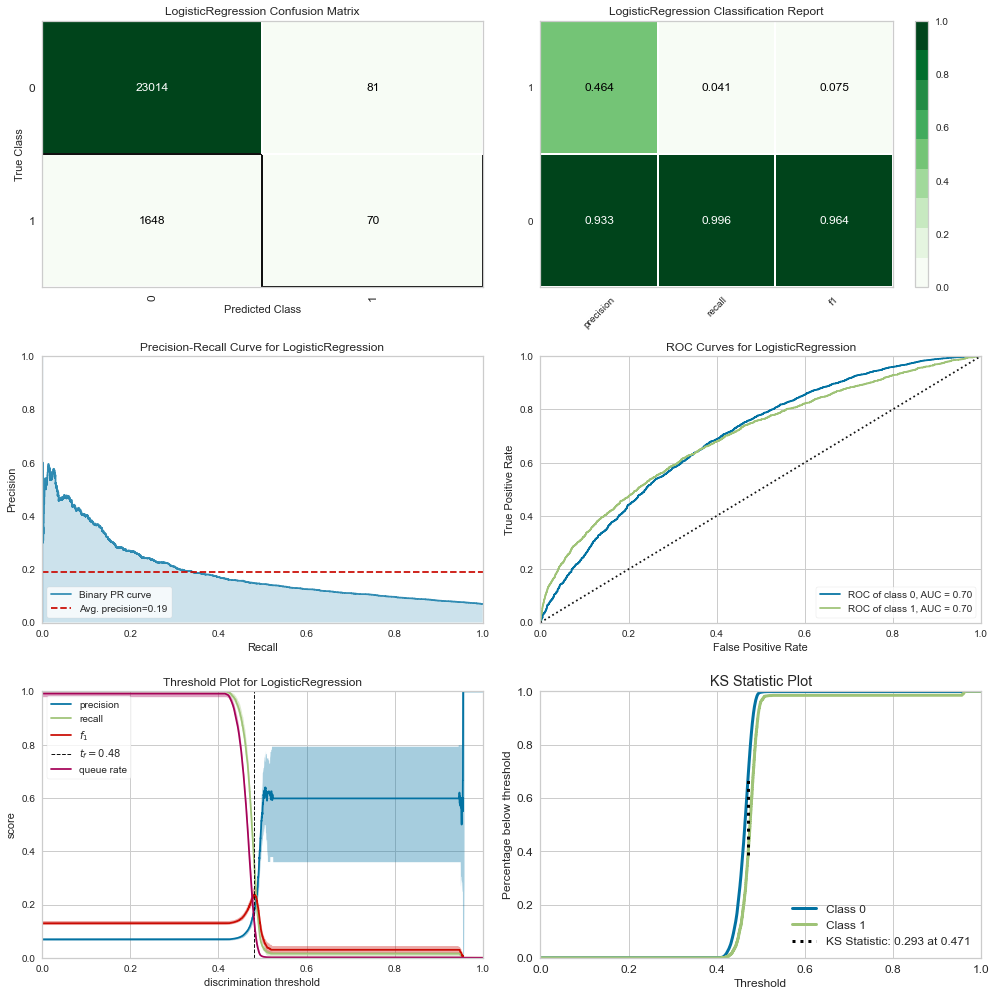

<Figure size 576x396 with 0 Axes>

In [7]:
viz_performance(X_train, X_test, y_train, y_test, reglog, ['0', '1'], figsize=(14,14))
plt.savefig(os.path.join(IMG_PATH,'reglog-metrics.png'), format='png')

## Model Selection

In [8]:
models = [
          ('DecisionTree', DecisionTreeClassifier(random_state=SEED)),
          ('RandomForest', RandomForestClassifier(random_state=SEED)),
          ('ExtraTree', ExtraTreesClassifier(random_state=SEED)),
          ('Adaboost', AdaBoostClassifier(random_state=SEED)),
          ('XGBoost', xgb.XGBClassifier(random_state=SEED, verbosity=0)),
          ('LightGBM', lgbm.LGBMClassifier(random_state=SEED)),
          ('LogisticRegression', LogisticRegression(random_state=SEED, solver='saga')),
          ('SVC', SVC(random_state=SEED))
          ]

In [9]:
original = pd.DataFrame()

for name, model in tqdm(models):
    

    kfold = KFold(n_splits=3, random_state=SEED, shuffle=True)
    score = cross_validate(model, X_train, y_train, cv=kfold, scoring=['precision_weighted','recall_weighted','f1_weighted'], return_train_score=True)        
    additional = pd.DataFrame({
        'precision_train':np.mean(score['train_precision_weighted']),
        'precision_test':np.mean(score['test_precision_weighted']),
        'recall_train':np.mean(score['train_recall_weighted']),
        'recall_test':np.mean(score['test_recall_weighted']),
        'f1_train':np.mean(score['train_f1_weighted']),
        'f1_test':np.mean(score['test_f1_weighted']),
    }, index=[name])

    new = pd.concat([original, additional], axis=0)
    original = new

original

  0%|          | 0/8 [00:00<?, ?it/s]

,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test
DecisionTree,0.999732,0.898126,0.999732,0.891081,0.999732,0.894489
RandomForest,0.999706,0.914207,0.999706,0.932707,0.999706,0.916602
ExtraTree,0.999732,0.913224,0.999732,0.932137,0.999732,0.916123
Adaboost,0.916894,0.915780,0.933864,0.933294,0.918925,0.918050
XGBoost,0.955353,0.914123,0.956560,0.932154,0.948488,0.917375
LightGBM,0.938969,0.916002,0.945169,0.933743,0.932096,0.917106
LogisticRegression,0.890947,0.889181,0.930729,0.930703,0.897446,0.897399
SVC,0.866337,0.866338,0.930772,0.930772,0.897400,0.897400


  0%|          | 0/8 [00:00<?, ?it/s]

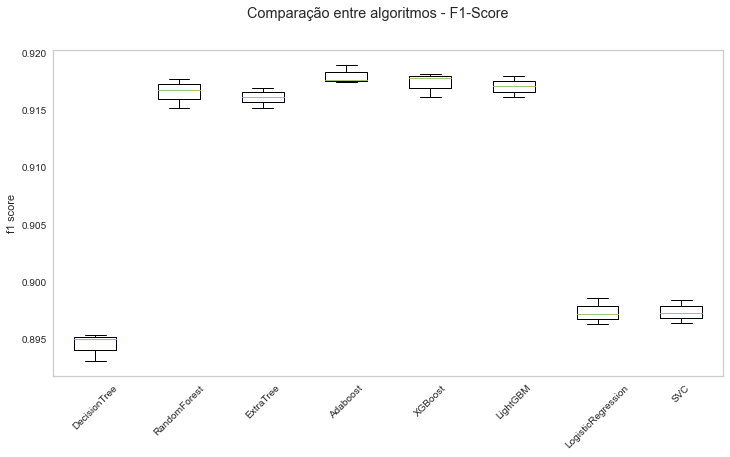

<Figure size 576x396 with 0 Axes>

In [10]:
results = []
names = []

for name, model in tqdm(models):
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=('f1_weighted'))
    results.append(cv_results)
    names.append(name)

fig = plt.figure(figsize=(12,6))
fig.suptitle('Comparação entre algoritmos - F1-Score')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.ylabel('f1 score')
plt.xticks(rotation=45)
plt.grid(b=False)
plt.show()

plt.savefig(os.path.join(IMG_PATH,'models-score.png'), format='png')

* Observando a métrica F1 Score plotada no gráfico de comparação dos algoritmos, é possível ressaltar que os algoritmos XGBoost, LightGBM e Adaboost possuem uma melhor performance bem como um menor desvio padrão entre os _folds_.

## LightGBM

In [11]:
param_hyperopt= {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1)),
    'max_depth': scope.int(hp.quniform('max_depth', 5, 20, 1)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 5, 100, 1)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 5, 35, 1)),
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart']),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 20.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 20.0),
    'feature_fraction': hp.uniform('feature_fraction', 0.3, 1.0)
}

In [12]:
best_param, model = hyperopt(param_hyperopt, X_train, y_train, X_test, y_test, num_eval=100)

[LightGBM] [Warning] feature_fraction is set=0.8503844764813029, colsample_bytree=0.6921119913621526 will be ignored. Current value: feature_fraction=0.8503844764813029
[LightGBM] [Warning] feature_fraction is set=0.8503844764813029, colsample_bytree=0.6921119913621526 will be ignored. Current value: feature_fraction=0.8503844764813029
[LightGBM] [Warning] feature_fraction is set=0.8503844764813029, colsample_bytree=0.6921119913621526 will be ignored. Current value: feature_fraction=0.8503844764813029
[LightGBM] [Warning] feature_fraction is set=0.8503844764813029, colsample_bytree=0.6921119913621526 will be ignored. Current value: feature_fraction=0.8503844764813029
[LightGBM] [Warning] feature_fraction is set=0.8503844764813029, colsample_bytree=0.6921119913621526 will be ignored. Current value: feature_fraction=0.8503844764813029
[LightGBM] [Warning] feature_fraction is set=0.3409410301359157, colsample_bytree=0.7022779271309514 will be ignored. Current value: feature_fraction=0.340

[LightGBM] [Warning] feature_fraction is set=0.5338250530827793, colsample_bytree=0.9654799173420916 will be ignored. Current value: feature_fraction=0.5338250530827793
[LightGBM] [Warning] feature_fraction is set=0.5338250530827793, colsample_bytree=0.9654799173420916 will be ignored. Current value: feature_fraction=0.5338250530827793
[LightGBM] [Warning] feature_fraction is set=0.813404448393648, colsample_bytree=0.9675483082075919 will be ignored. Current value: feature_fraction=0.813404448393648
[LightGBM] [Warning] feature_fraction is set=0.813404448393648, colsample_bytree=0.9675483082075919 will be ignored. Current value: feature_fraction=0.813404448393648
[LightGBM] [Warning] feature_fraction is set=0.813404448393648, colsample_bytree=0.9675483082075919 will be ignored. Current value: feature_fraction=0.813404448393648
[LightGBM] [Warning] feature_fraction is set=0.813404448393648, colsample_bytree=0.9675483082075919 will be ignored. Current value: feature_fraction=0.8134044483

[LightGBM] [Warning] feature_fraction is set=0.840598713676624, colsample_bytree=0.6904318788096493 will be ignored. Current value: feature_fraction=0.840598713676624
[LightGBM] [Warning] feature_fraction is set=0.840598713676624, colsample_bytree=0.6904318788096493 will be ignored. Current value: feature_fraction=0.840598713676624
[LightGBM] [Warning] feature_fraction is set=0.840598713676624, colsample_bytree=0.6904318788096493 will be ignored. Current value: feature_fraction=0.840598713676624
[LightGBM] [Warning] feature_fraction is set=0.840598713676624, colsample_bytree=0.6904318788096493 will be ignored. Current value: feature_fraction=0.840598713676624
[LightGBM] [Warning] feature_fraction is set=0.5292713794234347, colsample_bytree=0.902228530032541 will be ignored. Current value: feature_fraction=0.5292713794234347
[LightGBM] [Warning] feature_fraction is set=0.5292713794234347, colsample_bytree=0.902228530032541 will be ignored. Current value: feature_fraction=0.5292713794234

[LightGBM] [Warning] feature_fraction is set=0.6096995921902929, colsample_bytree=0.9129370743580686 will be ignored. Current value: feature_fraction=0.6096995921902929
[LightGBM] [Warning] feature_fraction is set=0.515822637753622, colsample_bytree=0.6522096273686998 will be ignored. Current value: feature_fraction=0.515822637753622
[LightGBM] [Warning] feature_fraction is set=0.515822637753622, colsample_bytree=0.6522096273686998 will be ignored. Current value: feature_fraction=0.515822637753622
[LightGBM] [Warning] feature_fraction is set=0.515822637753622, colsample_bytree=0.6522096273686998 will be ignored. Current value: feature_fraction=0.515822637753622
[LightGBM] [Warning] feature_fraction is set=0.515822637753622, colsample_bytree=0.6522096273686998 will be ignored. Current value: feature_fraction=0.515822637753622
[LightGBM] [Warning] feature_fraction is set=0.515822637753622, colsample_bytree=0.6522096273686998 will be ignored. Current value: feature_fraction=0.515822637753

[LightGBM] [Warning] feature_fraction is set=0.30143626803719725, colsample_bytree=0.7192085926847014 will be ignored. Current value: feature_fraction=0.30143626803719725
[LightGBM] [Warning] feature_fraction is set=0.30143626803719725, colsample_bytree=0.7192085926847014 will be ignored. Current value: feature_fraction=0.30143626803719725
[LightGBM] [Warning] feature_fraction is set=0.30143626803719725, colsample_bytree=0.7192085926847014 will be ignored. Current value: feature_fraction=0.30143626803719725
[LightGBM] [Warning] feature_fraction is set=0.9004969862567673, colsample_bytree=0.8078040850792042 will be ignored. Current value: feature_fraction=0.9004969862567673
[LightGBM] [Warning] feature_fraction is set=0.9004969862567673, colsample_bytree=0.8078040850792042 will be ignored. Current value: feature_fraction=0.9004969862567673
[LightGBM] [Warning] feature_fraction is set=0.9004969862567673, colsample_bytree=0.8078040850792042 will be ignored. Current value: feature_fraction

[LightGBM] [Warning] feature_fraction is set=0.8073491996738077, colsample_bytree=0.684767269642099 will be ignored. Current value: feature_fraction=0.8073491996738077
[LightGBM] [Warning] feature_fraction is set=0.8073491996738077, colsample_bytree=0.684767269642099 will be ignored. Current value: feature_fraction=0.8073491996738077
[LightGBM] [Warning] feature_fraction is set=0.8073491996738077, colsample_bytree=0.684767269642099 will be ignored. Current value: feature_fraction=0.8073491996738077
[LightGBM] [Warning] feature_fraction is set=0.8073491996738077, colsample_bytree=0.684767269642099 will be ignored. Current value: feature_fraction=0.8073491996738077
[LightGBM] [Warning] feature_fraction is set=0.8073491996738077, colsample_bytree=0.684767269642099 will be ignored. Current value: feature_fraction=0.8073491996738077
[LightGBM] [Warning] feature_fraction is set=0.855767400752088, colsample_bytree=0.675430726190125 will be ignored. Current value: feature_fraction=0.8557674007

[LightGBM] [Warning] feature_fraction is set=0.8029346943198213, colsample_bytree=0.7913537160889946 will be ignored. Current value: feature_fraction=0.8029346943198213
[LightGBM] [Warning] feature_fraction is set=0.8029346943198213, colsample_bytree=0.7913537160889946 will be ignored. Current value: feature_fraction=0.8029346943198213
[LightGBM] [Warning] feature_fraction is set=0.9258817475265617, colsample_bytree=0.705730438220363 will be ignored. Current value: feature_fraction=0.9258817475265617
[LightGBM] [Warning] feature_fraction is set=0.9258817475265617, colsample_bytree=0.705730438220363 will be ignored. Current value: feature_fraction=0.9258817475265617
[LightGBM] [Warning] feature_fraction is set=0.9258817475265617, colsample_bytree=0.705730438220363 will be ignored. Current value: feature_fraction=0.9258817475265617
[LightGBM] [Warning] feature_fraction is set=0.9258817475265617, colsample_bytree=0.705730438220363 will be ignored. Current value: feature_fraction=0.9258817

[LightGBM] [Warning] feature_fraction is set=0.866422151293248, colsample_bytree=0.7130531359723756 will be ignored. Current value: feature_fraction=0.866422151293248
[LightGBM] [Warning] feature_fraction is set=0.866422151293248, colsample_bytree=0.7130531359723756 will be ignored. Current value: feature_fraction=0.866422151293248
[LightGBM] [Warning] feature_fraction is set=0.866422151293248, colsample_bytree=0.7130531359723756 will be ignored. Current value: feature_fraction=0.866422151293248
[LightGBM] [Warning] feature_fraction is set=0.866422151293248, colsample_bytree=0.7130531359723756 will be ignored. Current value: feature_fraction=0.866422151293248
[LightGBM] [Warning] feature_fraction is set=0.9403629284299594, colsample_bytree=0.7613649226870751 will be ignored. Current value: feature_fraction=0.9403629284299594
[LightGBM] [Warning] feature_fraction is set=0.9403629284299594, colsample_bytree=0.7613649226870751 will be ignored. Current value: feature_fraction=0.94036292842

[LightGBM] [Warning] feature_fraction is set=0.9083433451545142, colsample_bytree=0.7304163376167162 will be ignored. Current value: feature_fraction=0.9083433451545142
[LightGBM] [Warning] feature_fraction is set=0.8813633519923525, colsample_bytree=0.765399753587548 will be ignored. Current value: feature_fraction=0.8813633519923525
[LightGBM] [Warning] feature_fraction is set=0.8813633519923525, colsample_bytree=0.765399753587548 will be ignored. Current value: feature_fraction=0.8813633519923525
[LightGBM] [Warning] feature_fraction is set=0.8813633519923525, colsample_bytree=0.765399753587548 will be ignored. Current value: feature_fraction=0.8813633519923525
[LightGBM] [Warning] feature_fraction is set=0.8813633519923525, colsample_bytree=0.765399753587548 will be ignored. Current value: feature_fraction=0.8813633519923525
[LightGBM] [Warning] feature_fraction is set=0.8813633519923525, colsample_bytree=0.765399753587548 will be ignored. Current value: feature_fraction=0.88136335

[LightGBM] [Warning] feature_fraction is set=0.9000538285836681, colsample_bytree=0.6127582922667992 will be ignored. Current value: feature_fraction=0.9000538285836681
[LightGBM] [Warning] feature_fraction is set=0.9000538285836681, colsample_bytree=0.6127582922667992 will be ignored. Current value: feature_fraction=0.9000538285836681
[LightGBM] [Warning] feature_fraction is set=0.9000538285836681, colsample_bytree=0.6127582922667992 will be ignored. Current value: feature_fraction=0.9000538285836681
[LightGBM] [Warning] feature_fraction is set=0.8534566670101833, colsample_bytree=0.7940418478348095 will be ignored. Current value: feature_fraction=0.8534566670101833
[LightGBM] [Warning] feature_fraction is set=0.8534566670101833, colsample_bytree=0.7940418478348095 will be ignored. Current value: feature_fraction=0.8534566670101833
[LightGBM] [Warning] feature_fraction is set=0.8534566670101833, colsample_bytree=0.7940418478348095 will be ignored. Current value: feature_fraction=0.853

[LightGBM] [Warning] feature_fraction is set=0.6369487348654597, colsample_bytree=0.6816939236442165 will be ignored. Current value: feature_fraction=0.6369487348654597
[LightGBM] [Warning] feature_fraction is set=0.6369487348654597, colsample_bytree=0.6816939236442165 will be ignored. Current value: feature_fraction=0.6369487348654597
[LightGBM] [Warning] feature_fraction is set=0.6369487348654597, colsample_bytree=0.6816939236442165 will be ignored. Current value: feature_fraction=0.6369487348654597
[LightGBM] [Warning] feature_fraction is set=0.6369487348654597, colsample_bytree=0.6816939236442165 will be ignored. Current value: feature_fraction=0.6369487348654597
[LightGBM] [Warning] feature_fraction is set=0.7623645819366452, colsample_bytree=0.7019710818334919 will be ignored. Current value: feature_fraction=0.7623645819366452
[LightGBM] [Warning] feature_fraction is set=0.7623645819366452, colsample_bytree=0.7019710818334919 will be ignored. Current value: feature_fraction=0.762

In [13]:
pipe = Pipeline([('clf', model)])

pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[LightGBM] [Warning] feature_fraction is set=0.9417235540418001, colsample_bytree=0.7501233887320855 will be ignored. Current value: feature_fraction=0.9417235540418001
[[22892   203]
 [ 1442   276]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     23095
           1       0.58      0.16      0.25      1718

    accuracy                           0.93     24813
   macro avg       0.76      0.58      0.61     24813
weighted avg       0.92      0.93      0.92     24813



## Oversample and Undersample

In [14]:
pipe = Pipe_imb([('smote', RandomUnderSampler(random_state=SEED, sampling_strategy=0.3)), ('clf', model)])
pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[LightGBM] [Warning] feature_fraction is set=0.9417235540418001, colsample_bytree=0.7501233887320855 will be ignored. Current value: feature_fraction=0.9417235540418001
[[21646  1449]
 [  877   841]]
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     23095
           1       0.37      0.49      0.42      1718

    accuracy                           0.91     24813
   macro avg       0.66      0.71      0.68     24813
weighted avg       0.92      0.91      0.91     24813



## Modelo final

[LightGBM] [Warning] feature_fraction is set=0.9417235540418001, colsample_bytree=0.7501233887320855 will be ignored. Current value: feature_fraction=0.9417235540418001
[LightGBM] [Warning] feature_fraction is set=0.9417235540418001, colsample_bytree=0.7501233887320855 will be ignored. Current value: feature_fraction=0.9417235540418001
[LightGBM] [Warning] feature_fraction is set=0.9417235540418001, colsample_bytree=0.7501233887320855 will be ignored. Current value: feature_fraction=0.9417235540418001
[LightGBM] [Warning] feature_fraction is set=0.9417235540418001, colsample_bytree=0.7501233887320855 will be ignored. Current value: feature_fraction=0.9417235540418001
[LightGBM] [Warning] feature_fraction is set=0.9417235540418001, colsample_bytree=0.7501233887320855 will be ignored. Current value: feature_fraction=0.9417235540418001
[LightGBM] [Warning] feature_fraction is set=0.9417235540418001, colsample_bytree=0.7501233887320855 will be ignored. Current value: feature_fraction=0.941

[LightGBM] [Warning] feature_fraction is set=0.9417235540418001, colsample_bytree=0.7501233887320855 will be ignored. Current value: feature_fraction=0.9417235540418001
[LightGBM] [Warning] feature_fraction is set=0.9417235540418001, colsample_bytree=0.7501233887320855 will be ignored. Current value: feature_fraction=0.9417235540418001


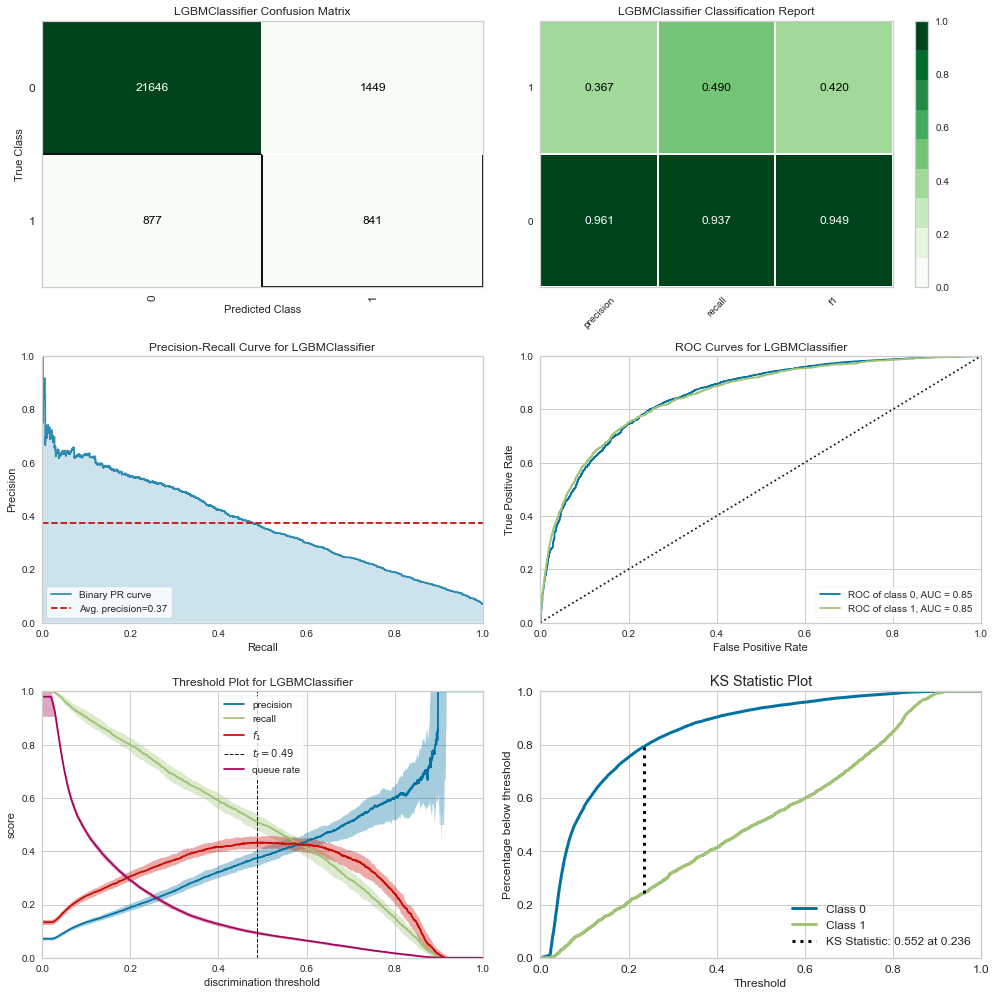

<Figure size 576x396 with 0 Axes>

In [15]:
viz_performance(X_train, X_test, y_train, y_test, pipe, ['0', '1'], figsize=(14,14))
plt.savefig(os.path.join(IMG_PATH,'lgbm-metrics.png'), format='png')

## Salvando Modelo

In [16]:
pickle.dump(pipe, open(os.path.join(MODEL_PATH,MODEL_NAME), 'wb'))

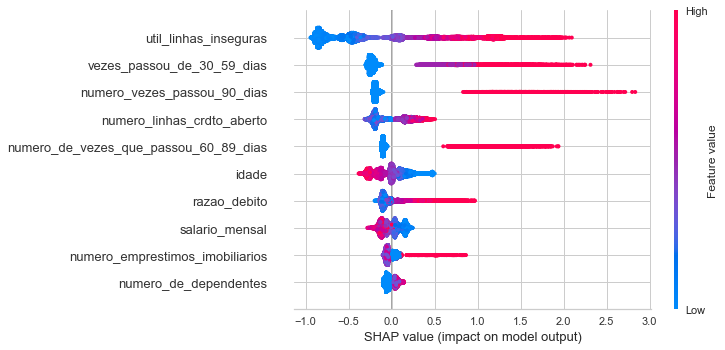

<Figure size 576x396 with 0 Axes>

In [17]:
explainer = shap.TreeExplainer(pipe['clf'])
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test)
plt.savefig(os.path.join(IMG_PATH,'shap-values.png'), format='png')

## Previsão

In [18]:
modelo = pickle.load(open(os.path.join(MODEL_PATH,MODEL_NAME), 'rb'))
test['inadimplente_predict'] = modelo.predict(test)

## Salvando previsão

In [19]:
test.to_csv(os.path.join(DATA_PREDICT, DATA_PREDICT_NAME), index=False)

## Considerações

* Como mostrado no notebook **02_Eda-and-feature-select** no tópico de **feature select** a variável de mais importancia para o model é **util_linhas_inseguras**.
* O teste de KS mostrou uma separação das distribuição acumulada entre os clientes inadimplentes e não inadimplentes boa;
* Normalmente para modelos de crédito utiliza-se KS como a métrica do negócio. Caso haja a necessidade de ter um modelo que otimize Precision ou Recall conseguimos variar o threshold que mostra no gráfico KS Statistic Plot e então avaliarmos com o gráfico Threshold Plot. Vale ressaltar que em modelos de crédito é habitualmente utilizado políticas para aprovar ou não um cliente com base no score que o modelo fornece;
* As técnicas de re-amostragem utilizada para balancear o target consistem na mudança da distribuição da variável, de modo a equilibrar a quantidade de observações de diferentes classes.